In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout ,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os
import imutils
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

In [ ]:
labels = ['Glioma','Meningioma', 'Normal', 'Pituitary']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                image = crop_brain_contour(img_arr, plot=False)
                resized_arr = cv2.resize(image, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot
!pip install cartopy
import cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 155673 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 155678 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.7_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 6.6 MB/s 
  Created wheel for libarchiv

In [ ]:
train = get_data('../content/drive/MyDrive/Ensemble data (1)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
x_train = []
y_train = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(x_train, y_train,stratify=y_train, test_size=0.20)
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_Train,stratify=Y_Train, test_size=0.10)
# Normalize the data
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_Test = np.array(X_Test) / 255

X_train.reshape(-1, img_size, img_size, 1)
Y_train = np.array(Y_train)

X_test.reshape(-1, img_size, img_size, 1)
Y_test = np.array(Y_test)

X_Test.reshape(-1, img_size, img_size, 1)
Y_Test = np.array(Y_Test)

print('Number of data in train set:', X_train.shape[0])
print('Number of data in test set:', X_Test.shape[0])
print('Number of data in validation set:', X_test.shape[0])

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_Test)
test_labels_encoded = le.transform(Y_Test)
le.fit(Y_train)
train_labels_encoded = le.transform(Y_train)

Number of data in train set: 2349
Number of data in test set: 653
Number of data in validation set: 262


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout ,BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D,AvgPool2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
from keras import regularizers
import numpy as np
from sklearn.metrics import mean_squared_error
import os


model2 = Sequential()

model2.add(Conv2D(16, kernel_size=3,kernel_initializer='he_uniform',padding='valid',strides=(1,1),activation='relu', input_shape=(224,224,3)))
model2.add(MaxPool2D(4,4))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=3,kernel_initializer='he_uniform', strides=(1,1),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
#model2.add(Dropout(0.3))

model2.add(Conv2D(64, kernel_size=3,kernel_initializer='he_uniform', strides=(1,1),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
#model2.add(Dropout(0.25))

model2.add(Conv2D(128, kernel_size=3,kernel_initializer='he_uniform', strides=(1,1),activation='relu'))
model2.add(AvgPool2D(2,2))
model2.add(BatchNormalization())
#model2.add(Dropout(0.25))

model2.add(Conv2D(128, kernel_size=3, kernel_initializer='he_uniform',strides=(1,1),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
#model2.add(Dropout(0.25))


#model2.add(Dropout(0.10))
model2.add(Flatten())
x=model2.output
x1=Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
x2=Dense(32, activation='relu',kernel_initializer='he_uniform')(x1)
prediction_layer=Dense(4, activation='softmax')(x2)
cnn_model=Model(inputs=model2.input, outputs=prediction_layer)
#cnn_model.save('/content/gdrive/MyDrive/model1.h5')
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 32)       0     

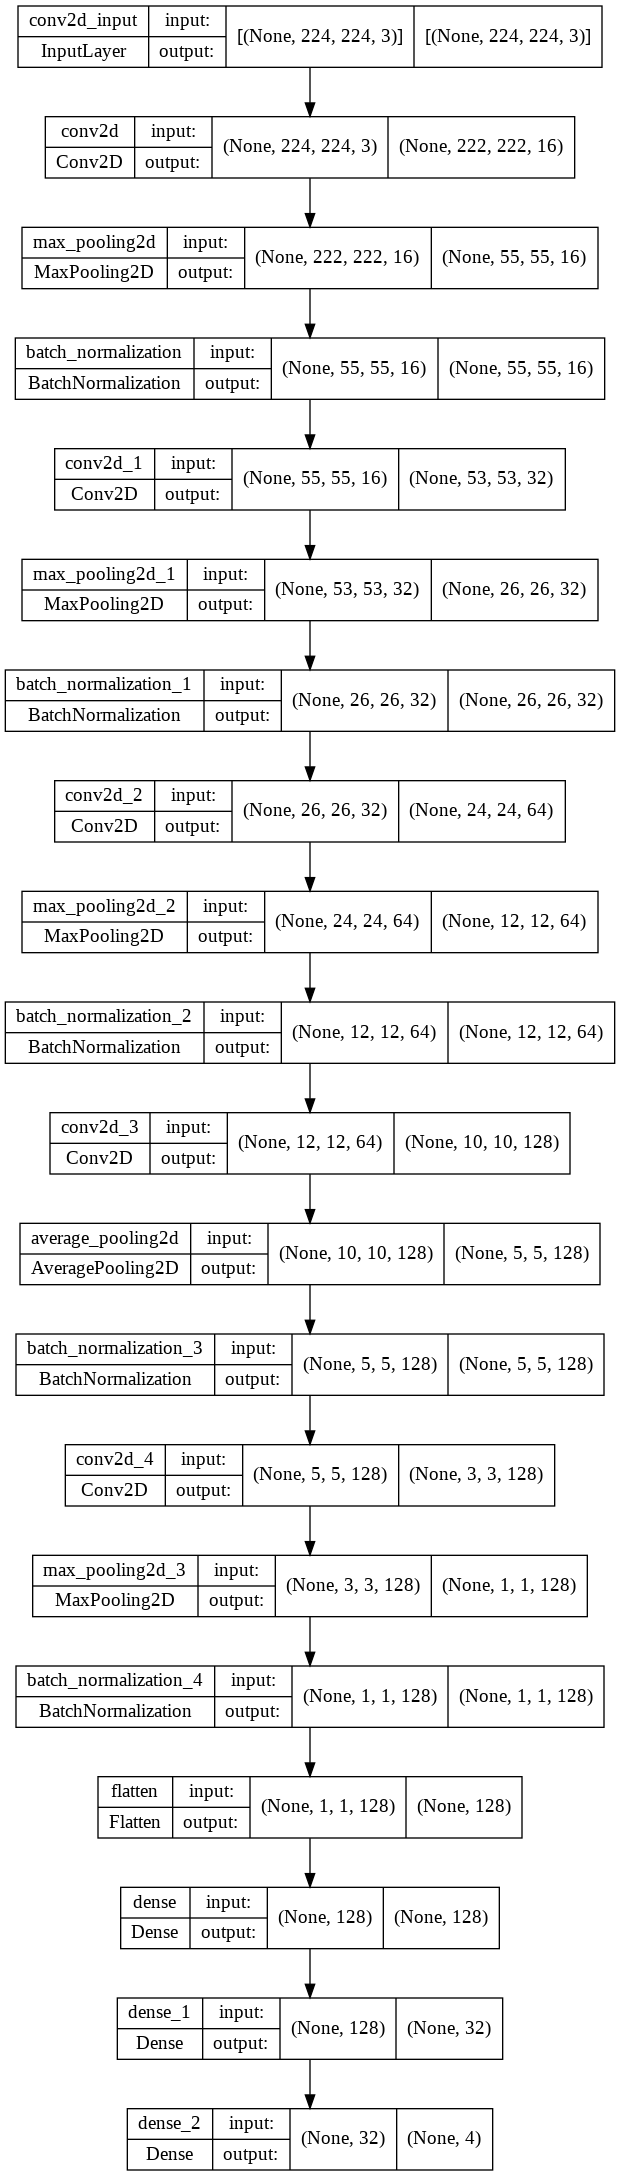

In [ ]:
# You can also plot the model as a graph:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

keras.utils.plot_model(cnn_model, "HEUNIFORM_model.png", show_shapes=True)

In [ ]:
keras.backend.clear_session()

cnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"],
)
history=cnn_model.fit(X_train,Y_train,epochs = 40 ,batch_size=16, validation_data = (X_test, Y_test),verbose=1)
#history = model.fit(train_images, train_labels, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/40
147/147 [==============================] - 15s 22ms/step - loss: 0.9178 - accuracy: 0.6505 - val_loss: 2.0221 - val_accuracy: 0.3588
Epoch 2/40
147/147 [==============================] - 2s 14ms/step - loss: 0.5624 - accuracy: 0.7846 - val_loss: 1.7297 - val_accuracy: 0.4771
Epoch 3/40
147/147 [==============================] - 2s 14ms/step - loss: 0.4054 - accuracy: 0.8412 - val_loss: 2.3904 - val_accuracy: 0.4771
Epoch 4/40
147/147 [==============================] - 2s 14ms/step - loss: 0.3387 - accuracy: 0.8804 - val_loss: 1.7420 - val_accuracy: 0.6069
Epoch 5/40
147/147 [==============================] - 2s 14ms/step - loss: 0.2796 - accuracy: 0.9068 - val_loss: 0.6490 - val_accuracy: 0.7557
Epoch 6/40
147/147 [==============================] - 2s 14ms/step - loss: 0.2155 - accuracy: 0.9246 - val_loss: 0.7714 - val_accuracy: 0.7137
Epoch 7/40
147/147 [==============================] - 2s 14ms/step - loss: 0.1636 - accuracy: 0.9476 - val_loss: 0.4280 - val_accuracy: 0.839

In [ ]:
# stop training if ==0.95

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if (logs.get('accuracy')>0.95):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True


callbacks = myCallback()

In [ ]:
''' Callbacks with Checkpoint'''

keras.backend.clear_session()

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
  # Saved the Best Model
filepath = "heuniform.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
  # callback list
callback_list = [acc_callback, checkpoint]

In [ ]:
cnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"],
)
history=cnn_model.fit(X_train,Y_train,epochs = 40 ,batch_size=16, validation_data = (X_test, Y_test),verbose=1,callbacks = [callback_list])
#history = cnn_model.fit(train_images, train_labels, batch_size=16, epochs=40, validation_split=0.2, callbacks = [callback_l

Epoch 1/40
147/147 [==============================] - ETA: 0s - loss: 0.8658 - accuracy: 0.6488
Epoch 1: val_accuracy improved from -inf to 0.38931, saving model to heuniform.h5
147/147 [==============================] - 16s 21ms/step - loss: 0.8658 - accuracy: 0.6488 - val_loss: 2.4655 - val_accuracy: 0.3893
Epoch 2/40
145/147 [============================>.] - ETA: 0s - loss: 0.5716 - accuracy: 0.7828
Epoch 2: val_accuracy improved from 0.38931 to 0.43130, saving model to heuniform.h5
147/147 [==============================] - 2s 15ms/step - loss: 0.5684 - accuracy: 0.7842 - val_loss: 2.6380 - val_accuracy: 0.4313
Epoch 3/40
145/147 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8638
Epoch 3: val_accuracy improved from 0.43130 to 0.59542, saving model to heuniform.h5
147/147 [==============================] - 2s 15ms/step - loss: 0.3851 - accuracy: 0.8629 - val_loss: 1.2388 - val_accuracy: 0.5954
Epoch 4/40
146/147 [============================>.] - ETA: 0s -

In [ ]:
# Recreate the exact same model purely from the file:
from tensorflow.keras.models import load_model
cnn_model = load_model("heuniform.h5")

              precision    recall  f1-score   support

      Glioma       0.92      0.88      0.90       185
  Meningioma       0.94      0.88      0.91       188
      Normal       0.88      0.99      0.93       100
   Pituitary       0.94      0.97      0.95       180

    accuracy                           0.92       653
   macro avg       0.92      0.93      0.92       653
weighted avg       0.92      0.92      0.92       653

Confusion Matrix
[[163  11   6   5]
 [ 12 165   4   7]
 [  1   0  99   0]
 [  1   0   4 175]]


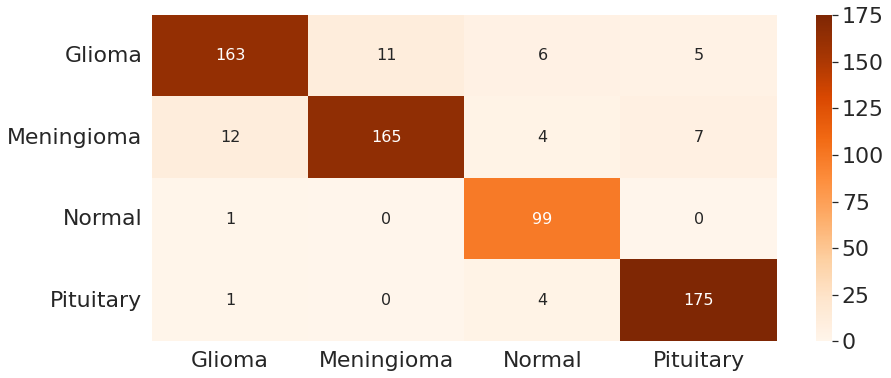

In [ ]:
target_names = ['Glioma','Meningioma','Normal','Pituitary']
predictions1 = cnn_model.predict(X_Test)
predictions1=np.argmax(predictions1,axis=1)
#predictions = predictions.reshape(1,-1)[0]
print(classification_report(Y_Test, predictions1, target_names = ['Glioma','Meningioma','Normal','Pituitary']))
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
print('Confusion Matrix')
print(confusion_matrix(Y_Test, predictions1))
cm=confusion_matrix(Y_Test, predictions1)
#plt.figure(figsize=(5, 5))
#plt.imshow(cm)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm, index=["Glioma","Meningioma","Normal","Pituitary"], columns=["Glioma","Meningioma","Normal","Pituitary"])
plt.figure(figsize=(14,6))
sn.set(font_scale=2) # for label size
sn.heatmap(df_cm, annot=True,cmap='Oranges',fmt ='d', annot_kws={"size": 16}) # font size

plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout ,BatchNormalization, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D,AvgPool2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import os
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

model2 = Sequential()
model2.add(model_input)
model2.add(Conv2D(16, kernel_size=3,kernel_initializer='he_uniform',padding='valid',strides=(1,1),activation='relu', input_shape=(224,224,3)))
model2.add(MaxPool2D(4,4))
model2.add(BatchNormalization())



model2.add(Conv2D(64, kernel_size=3,kernel_initializer='he_uniform', strides=(1,1),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())


model2.add(Conv2D(128, kernel_size=3,kernel_initializer='he_uniform', strides=(1,1),activation='relu'))
model2.add(AvgPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))




#model2.add(Dropout(0.10))
model2.add(Flatten())
x=model2.output





model = Sequential()
model.add(model_input)
model.add(Conv2D(32, kernel_size=3,kernel_initializer='glorot_uniform',padding='valid',strides=(1,1),activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=3,kernel_initializer='glorot_uniform', strides=(1,1),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=3,kernel_initializer='glorot_uniform', strides=(1,1),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
y=model.output

#features=np.concatenate(x,y)

concatenate_layer = Concatenate(name='concatenation')([x, y])

x1=Dense(128, activation='relu',kernel_initializer='he_uniform')(concatenate_layer)
x2=Dense(32, activation='relu',kernel_initializer='he_uniform')(x1)
prediction_layer=Dense(4, activation='softmax')(x2)
#p=model1.input
#q=model.input
#models=Concatenate(name='concatenation')([p, q])
#input1=model1.input
#input2=model.input
#concatInputs = keras.backend.concatenate([input1, input2],axis=0)
#cnn_models=Model(inputs=model_input, outputs=x2)
cnn_model1=Model(inputs=model_input, outputs=prediction_layer)
#cnn_model.save('/content/gdrive/MyDrive/model3.h5')
cnn_model1.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 222, 222, 32  896         ['input_1[0][0]']                
                                )                                                             

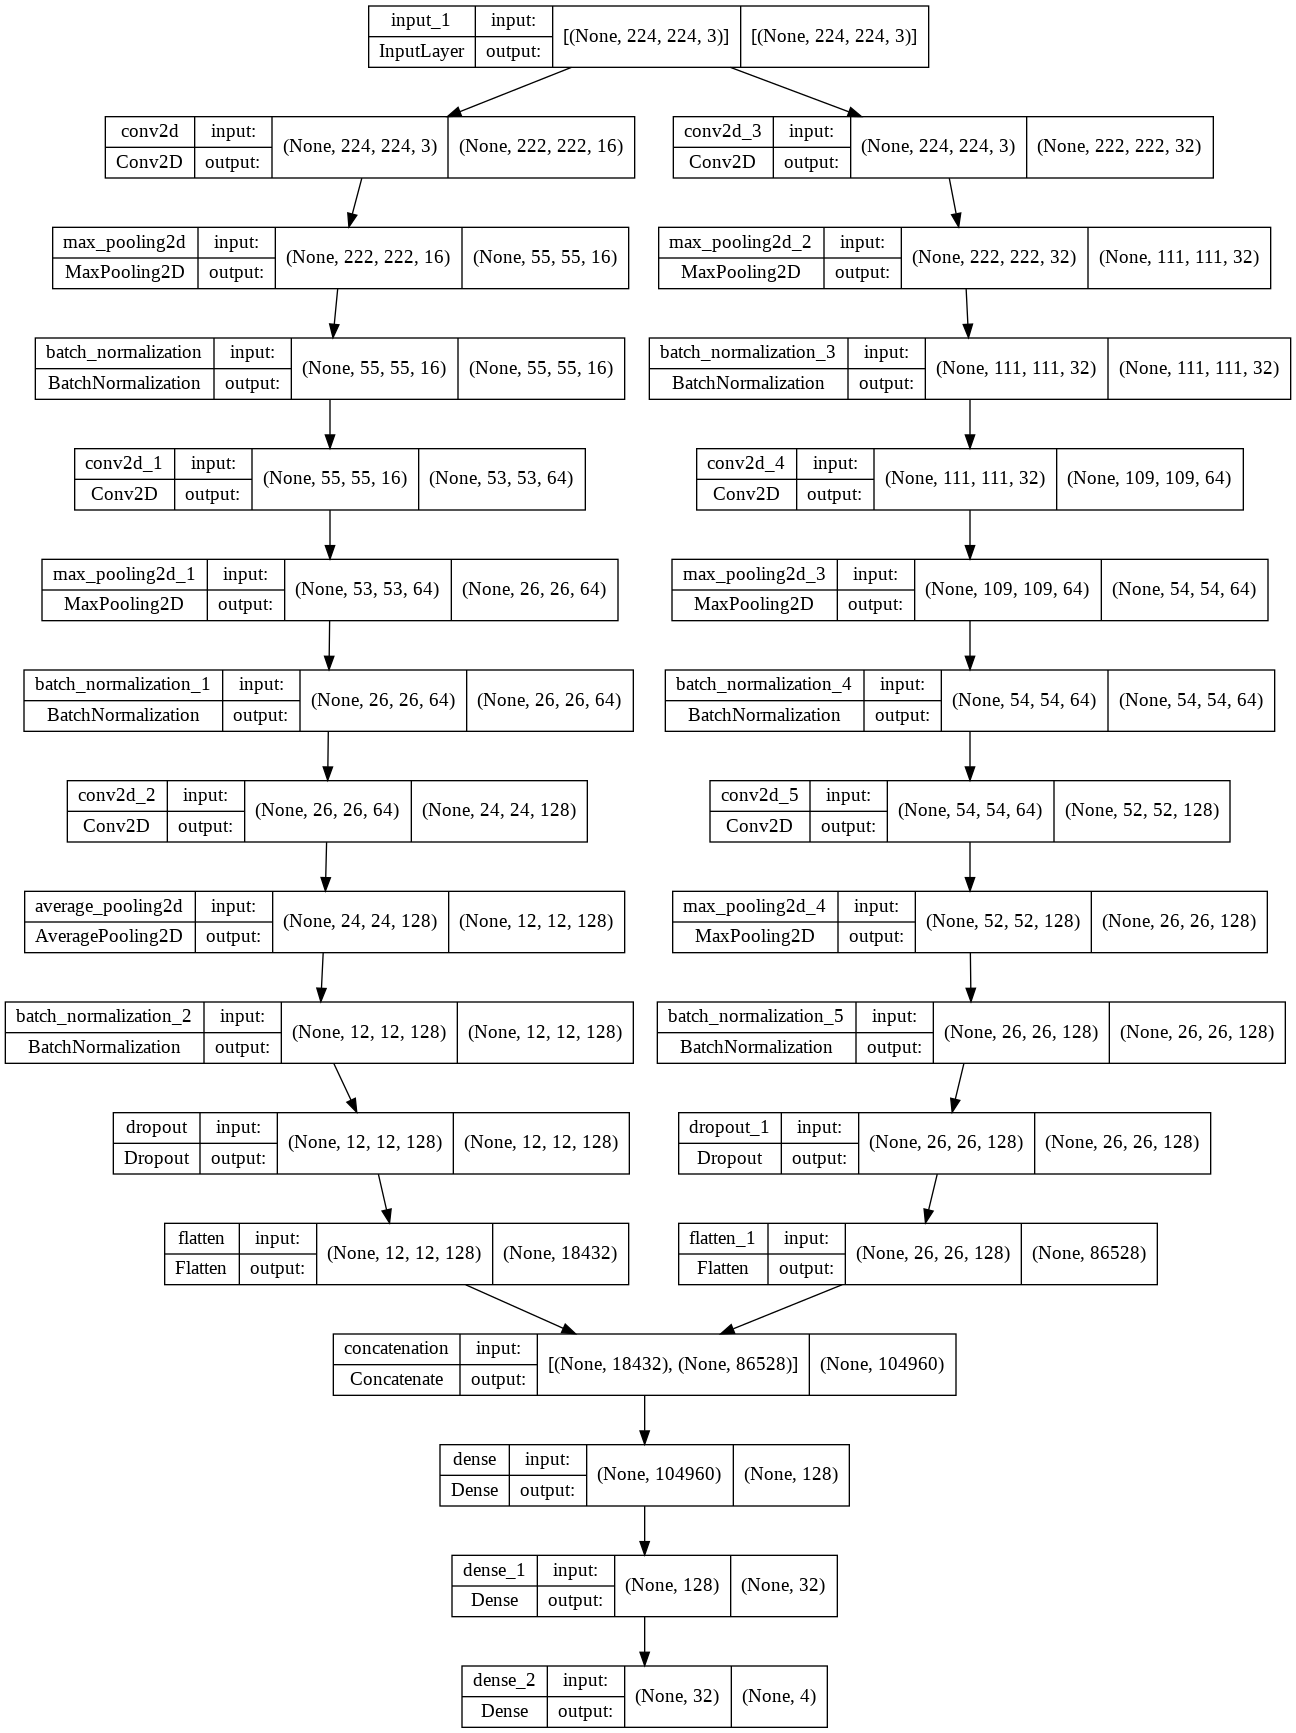

In [ ]:
# You can also plot the model as a graph:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

keras.utils.plot_model(cnn_model1, "FUSION_model.png", show_shapes=True)

In [ ]:
''' Callbacks with Checkpoint'''

keras.backend.clear_session()

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
  # Saved the Best Model
filepath = "fusion.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
  # callback list
callback_list = [acc_callback, checkpoint]

In [ ]:
cnn_model1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy'],
)
history=cnn_model1.fit(X_train,Y_train,epochs = 60 ,batch_size=16, validation_data = (X_test, Y_test),verbose=1)

Epoch 1/60
147/147 [==============================] - 22s 57ms/step - loss: 2.8480 - accuracy: 0.5832 - val_loss: 6.2352 - val_accuracy: 0.2863
Epoch 2/60
147/147 [==============================] - 6s 43ms/step - loss: 0.9916 - accuracy: 0.7693 - val_loss: 11.7183 - val_accuracy: 0.2939
Epoch 3/60
147/147 [==============================] - 7s 44ms/step - loss: 0.5578 - accuracy: 0.8544 - val_loss: 4.1919 - val_accuracy: 0.4122
Epoch 4/60
147/147 [==============================] - 6s 44ms/step - loss: 0.3031 - accuracy: 0.9140 - val_loss: 1.0170 - val_accuracy: 0.7748
Epoch 5/60
147/147 [==============================] - 6s 44ms/step - loss: 0.2271 - accuracy: 0.9293 - val_loss: 0.7306 - val_accuracy: 0.8359
Epoch 6/60
147/147 [==============================] - 7s 45ms/step - loss: 0.2687 - accuracy: 0.9293 - val_loss: 1.6066 - val_accuracy: 0.6985
Epoch 7/60
147/147 [==============================] - 6s 43ms/step - loss: 0.3546 - accuracy: 0.9089 - val_loss: 2.9236 - val_accuracy: 0.61

In [ ]:
# Recreate the exact same model purely from the file:
from tensorflow.keras.models import load_model
cnn_model1 = load_model("fusion.h5")

In [ ]:

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

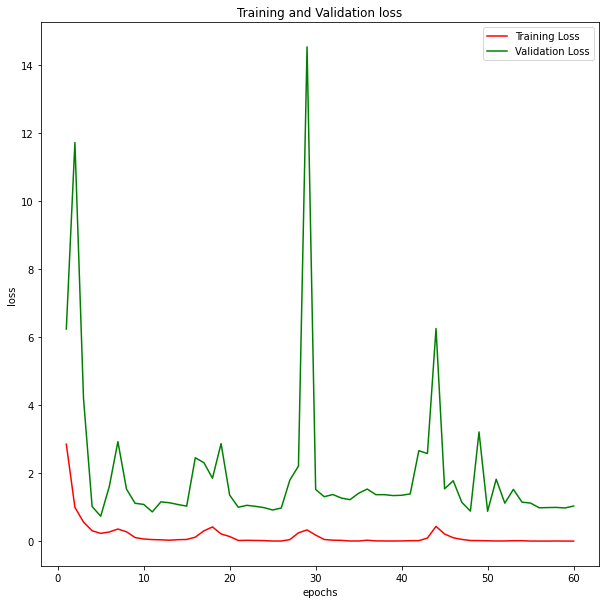

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()


<Figure size 432x288 with 0 Axes>

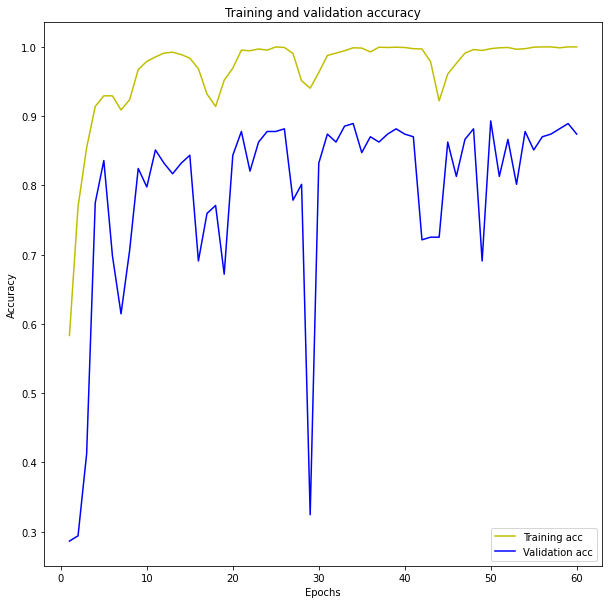

In [ ]:
plt.clf()   # clear figure
plt.figure(figsize=(10, 10))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

              precision    recall  f1-score   support

      Glioma       0.96      0.89      0.92       185
  Meningioma       0.86      0.96      0.91       188
      Normal       0.98      0.90      0.94       100
   Pituitary       0.97      0.98      0.98       180

    accuracy                           0.94       653
   macro avg       0.94      0.93      0.94       653
weighted avg       0.94      0.94      0.94       653

Confusion Matrix
[[164  19   1   1]
 [  2 181   1   4]
 [  2   8  90   0]
 [  2   2   0 176]]


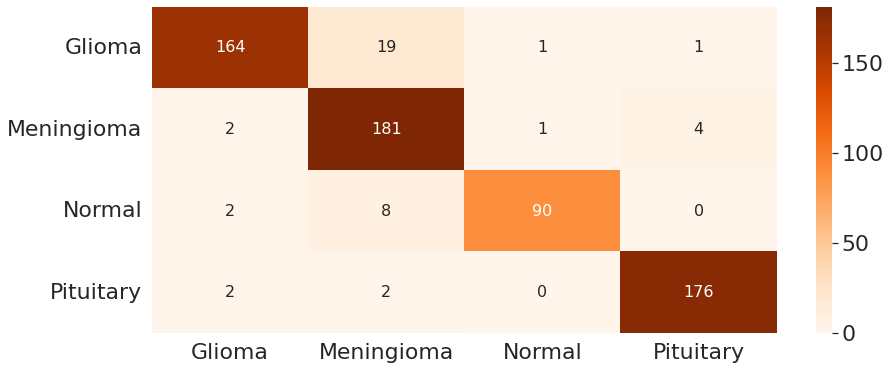

In [ ]:
target_names = ['Glioma','Meningioma','Normal','Pituitary']
predictions1 = cnn_model1.predict(X_Test)
predictions1=np.argmax(predictions1,axis=1)
#predictions = predictions.reshape(1,-1)[0]
print(classification_report(Y_Test, predictions1, target_names = ['Glioma','Meningioma','Normal','Pituitary']))
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
print('Confusion Matrix')
print(confusion_matrix(Y_Test, predictions1))
cm=confusion_matrix(Y_Test, predictions1)
#plt.figure(figsize=(5, 5))
#plt.imshow(cm)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm, index=["Glioma","Meningioma","Normal","Pituitary"], columns=["Glioma","Meningioma","Normal","Pituitary"])
plt.figure(figsize=(14,6))
sn.set(font_scale=2) # for label size
sn.heatmap(df_cm, annot=True,cmap='Oranges',fmt ='d', annot_kws={"size": 16}) # font size

plt.show()

Accuracy =  0.9479326186830015
Accuracy =  0.9494640122511485


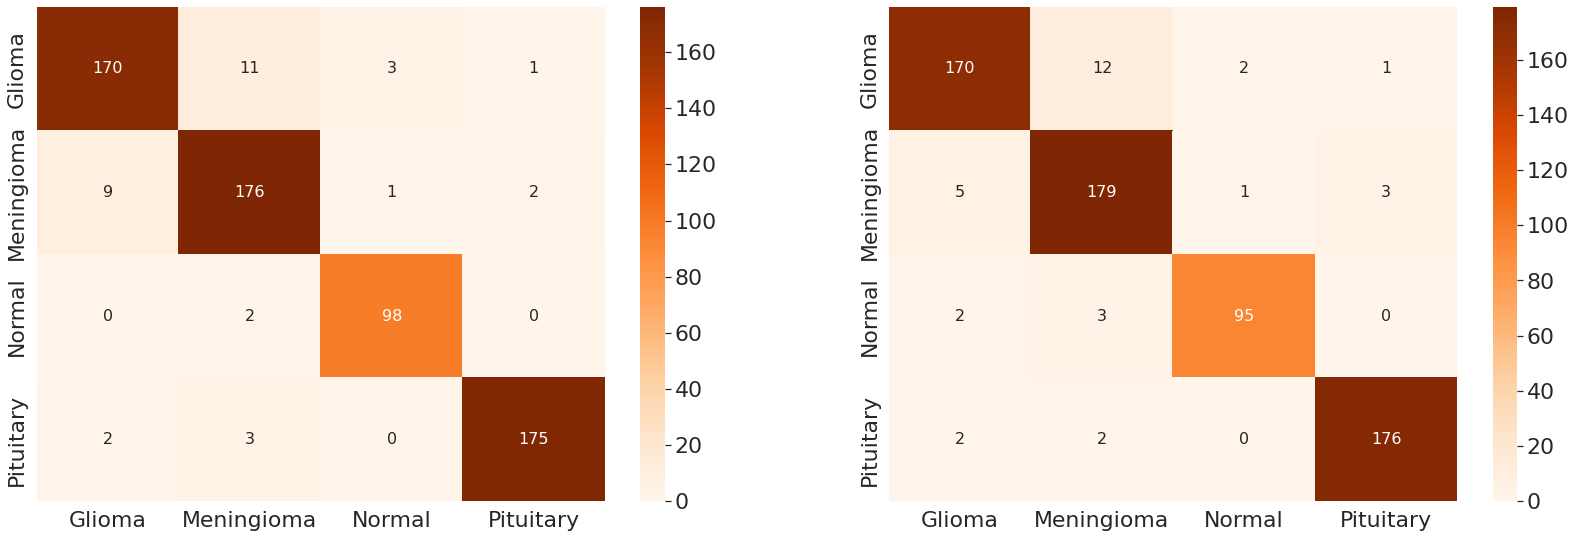

21/21 [==============================] - 1s 23ms/step - loss: 0.2207 - accuracy: 0.9357
Test loss: 0.22069770097732544
Test accuracy: 0.9356814622879028


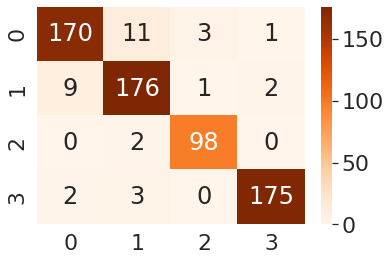

In [ ]:
#To use features from convolutional network for RF
X_for_RF = cnn_model1.predict(X_train) #This is out X input to RF

#Importing RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
RF_model = RandomForestClassifier(n_estimators = 50,random_state = 42)
SV_model = svm.SVC(kernel='rbf',gamma=0.2,C=2)
# Training the model on training data
RF_model=RF_model.fit(X_for_RF, train_labels_encoded) #For sklearn no one hot encoding
#epth=4,precision=2,class_names=target_names,fontsize=12,filled=True,impurity=True, node_ids=True, rotate=True, rounded=True)
SV_model.fit(X_for_RF, train_labels_encoded)
#Sending test data through same feature extractor process
X_test_feature = cnn_model1.predict(X_Test)
# predicting using the trained RF model.
prediction_RF = RF_model.predict(X_test_feature)
prediction_SV = SV_model.predict(X_test_feature)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)
prediction_SV = le.inverse_transform(prediction_SV)
#test_labels=['glioma','no tumor','pituitary']
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(Y_Test, prediction_RF))
print ("Accuracy = ", metrics.accuracy_score(Y_Test, prediction_SV))

#mse_train = mean_squared_error(train_labels_encoded, X_for_RF)
#mse_test = mean_squared_error(test_labels_encoded, prediction_RF)
#print("RF with pruned trees, Train MSE: {} Test MSE: {}".format(mse_train, mse_test))

#Confusion Matrix - verifying accuracy of each class
cm = confusion_matrix(Y_Test, prediction_RF)
cm1 = confusion_matrix(Y_Test, prediction_SV)
#print(cm)
#sns.heatmap(cm, fmt='d',cmap='Blues',annot=True,)
df_cm1 = pd.DataFrame(cm, index=["Glioma","Meningioma","Normal","Pituitary"], columns=["Glioma","Meningioma","Normal","Pituitary"])
df_cm2=pd.DataFrame(cm1, index=["Glioma", "Meningioma","Normal","Pituitary"], columns=["Glioma","Meningioma","Normal","Pituitary"])
plt.figure(figsize=(28,20))
plt.subplot(2, 2, 1)
sn.set(font_scale=2) # for label size
sn.heatmap(df_cm1, annot=True,cmap='Oranges',fmt ='d', annot_kws={"size": 16}) # font size
plt.subplot(2, 2, 2)
sn.heatmap(df_cm2, annot=True,cmap='Oranges',fmt ='d', annot_kws={"size": 16}) # font size
plt.show()
sns.heatmap(cm, fmt='d',cmap='Oranges',annot=True,)
#Check results on a few select images
#n=5 #dog park. RF works better than CNN

test_eval = cnn_model1.evaluate(X_Test, test_labels_encoded, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


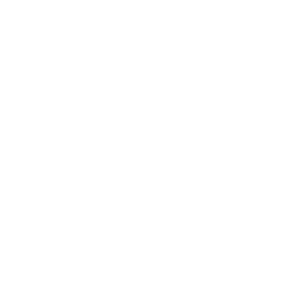

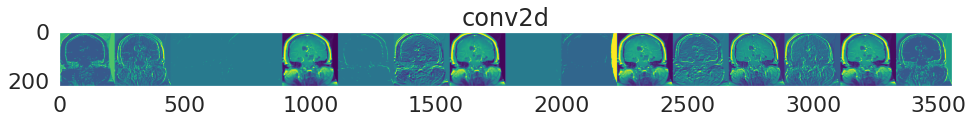

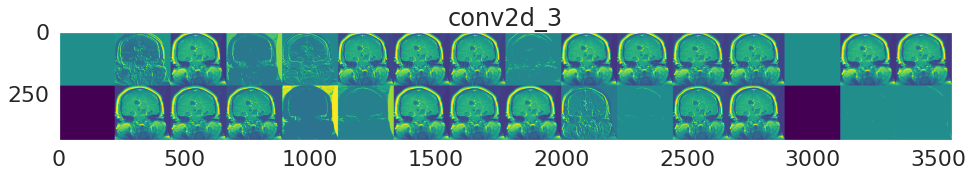

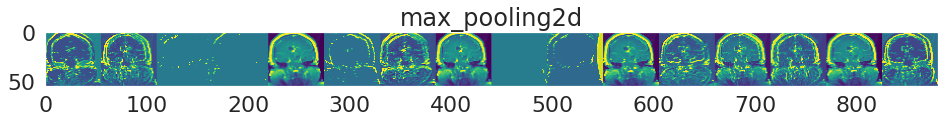

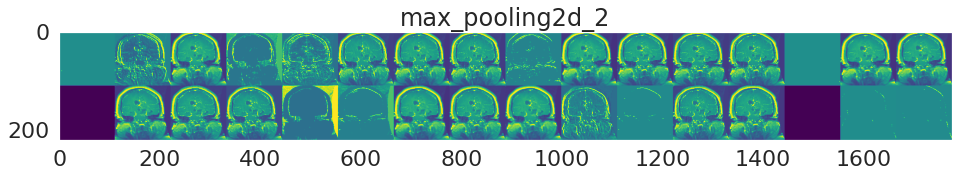

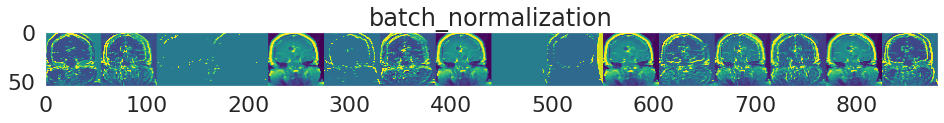

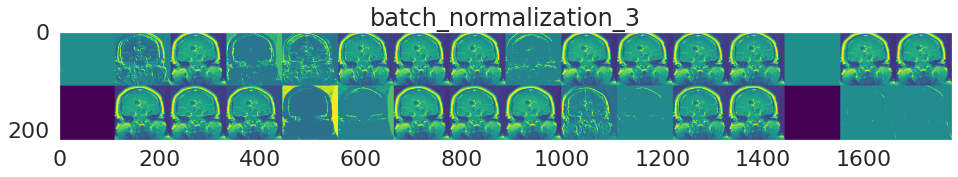

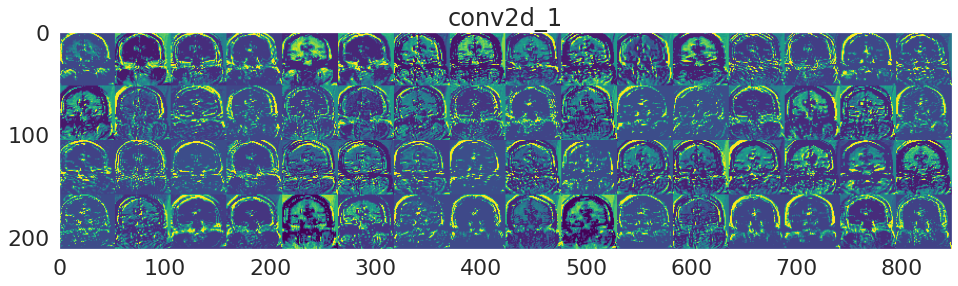

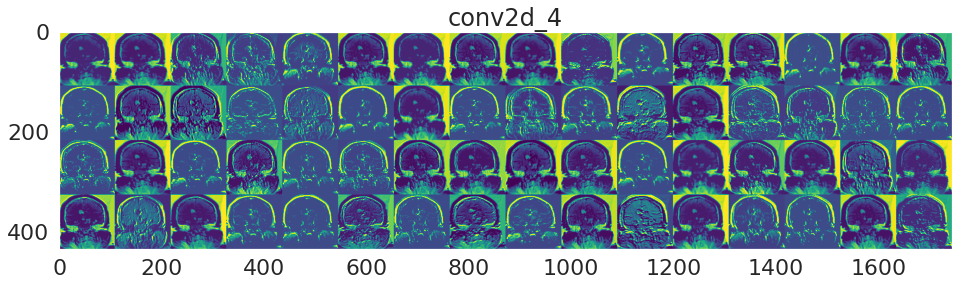

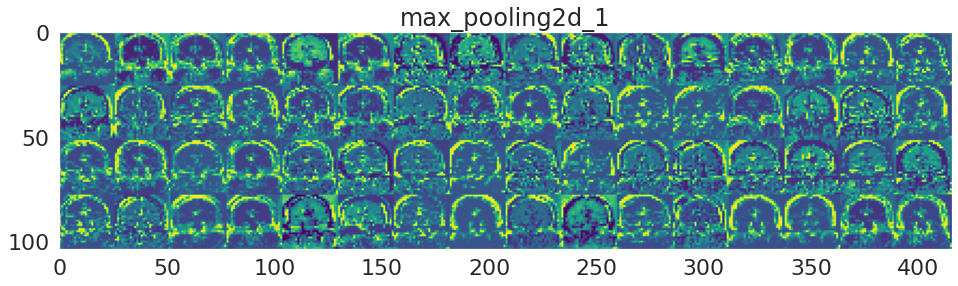

In [ ]:
layer_outputs = [layer.output for layer in cnn_model1.layers[1:10]]
activation_model = Model(inputs=cnn_model1.input,outputs=layer_outputs)
img = X_Test[50]
img = np.expand_dims(img, axis=0)
fig = plt.figure(figsize=(5,5))
#plt.imshow(img[0,:,:,0],cmap="gray")
plt.axis('off')
activations = activation_model.predict(img)
layer_names = []
for layer in cnn_model1.layers[1:10]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

The prediction for this image is:  [2]
The actual label for this image is:  2
21/21 [==============================] - 1s 34ms/step - loss: 0.2207 - accuracy: 0.9357
Test loss: 0.22069770097732544
Test accuracy: 0.9356814622879028
[3 3 3 0 3 2 0 1 3 3 2 3 2 2 3 0 3 0 1 1 1 3 2 1 3 1 0 3 0 0 0 1 2 1 1 0 2
 3 2 2 0 1 1 2 1 2 0 2 1 0 0 2 3 2 3 3 1 1 2 3 3 2 0 0 0 3 1 2 1 0 1 0 3 2
 0 0 2 3 2 2 0 1 2 0 0 2 1 0 1 1 0 2 3 1 1 3 0 1 1 0 3 1 2 3 1 1 3 2 2 0 1
 0 1 0 1 1 1 3 3 0 1 3 0 3 1 3 1 1 0 2 1 2 1 0 2 2 1 0 1 3 3 0 3 3 2 0 3 3
 3 3 0 0 1 3 0 1 2 3 1 2 1 0 3 0 1 0 1 2 1 1 0 0 0 3 3 1 2 3 1 0 1 3 0 0 3
 2 0 3 3 3 1 1 0 1 0 3 1 0 0 1 3 1 0 1 3 2 1 0 3 3 0 1 0 1 1 3 1 1 2 0 3 3
 2 3 1 3 3 0 0 3 3 2 3 1 2 3 1 3 3 3 2 1 3 0 3 0 0 1 3 1 0 3 0 3 1 3 0 0 0
 3 1 3 0 1 3 3 3 3 3 0 0 3 1 3 1 2 1 2 3 3 1 3 0 1 0 1 1 1 1 1 2 0 0 1 0 2
 0 0 0 1 3 0 3 3 3 0 3 2 2 0 1 1 0 0 2 2 1 3 3 1 1 0 3 3 1 0 2 1 3 0 0 2 2
 0 0 2 0 0 2 1 3 2 3 0 0 1 0 0 1 1 1 0 0 3 3 3 0 0 1 1 1 1 0 2 3 1 1 3 0 1
 0 3 2 2 3 3 1 0 2 

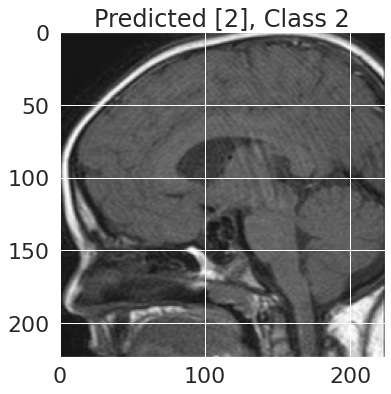

In [ ]:
n=22 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = RF_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()
test_eval = cnn_model1.evaluate(X_Test, test_labels_encoded, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
prediction_RF = RF_model.predict(X_test_feature)
print(Y_Test, prediction_SV)

The prediction for this image is:  [0]
The actual label for this image is:  0


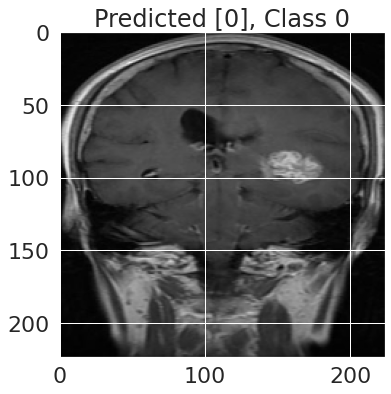

In [ ]:
n=150 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = RF_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [3]
The actual label for this image is:  3


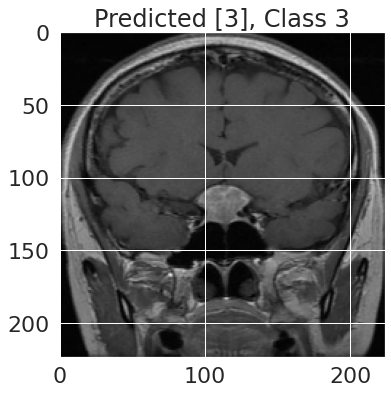

In [ ]:
n=220 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = RF_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [1]
The actual label for this image is:  1


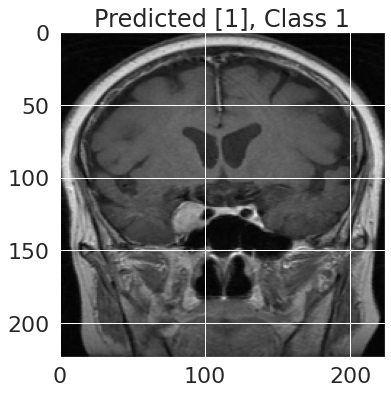

In [ ]:
n=559 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = RF_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [2]
The actual label for this image is:  2


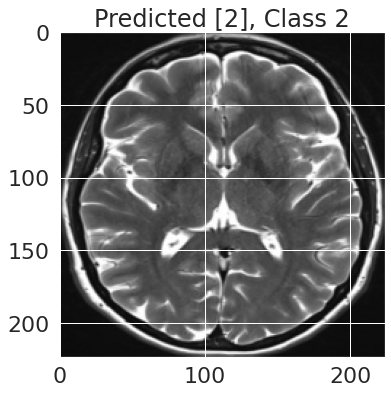

In [ ]:
n=5 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = RF_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [2]
The actual label for this image is:  2


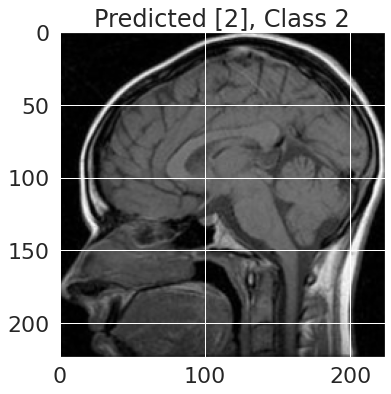

In [ ]:
n=622 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [1]
The actual label for this image is:  1


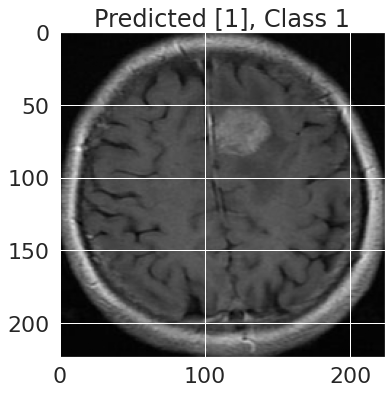

In [ ]:
n=345 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [1]
The actual label for this image is:  0


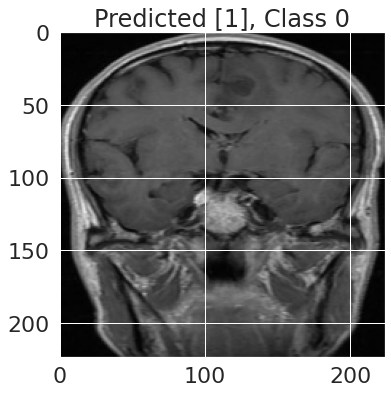

In [ ]:
n=111 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [1]
The actual label for this image is:  1


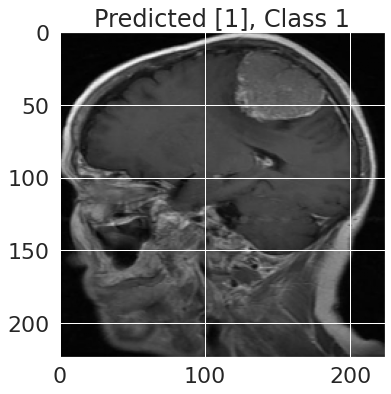

In [ ]:
n=112 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [0]
The actual label for this image is:  2


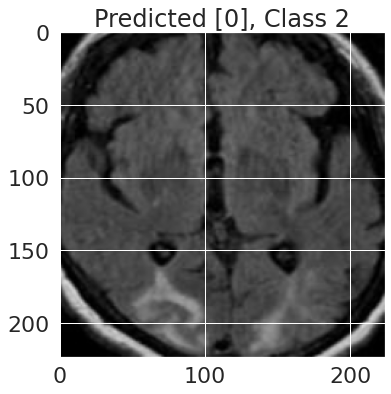

In [ ]:
n=222 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [0]
The actual label for this image is:  0


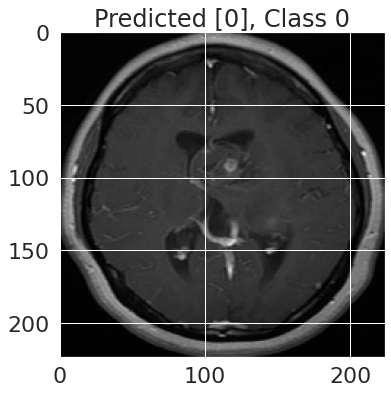

In [ ]:
n=333 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [1]
The actual label for this image is:  1


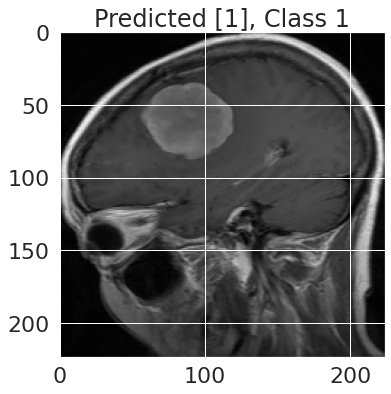

In [ ]:
n=444 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [2]
The actual label for this image is:  2


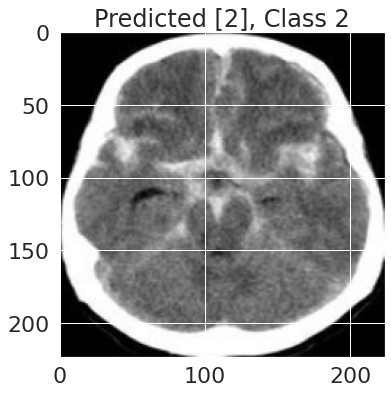

In [ ]:
n=650 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [0]
The actual label for this image is:  1


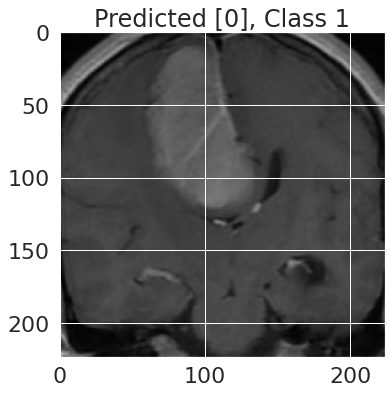

In [ ]:
n=599 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [2]
The actual label for this image is:  2


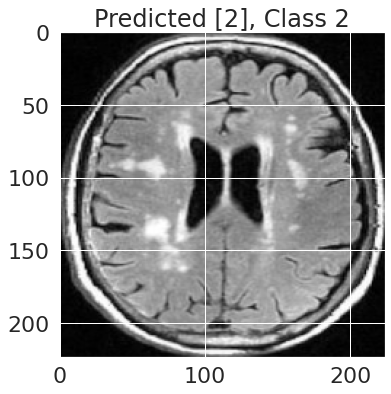

In [ ]:
n=399 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [3]
The actual label for this image is:  1


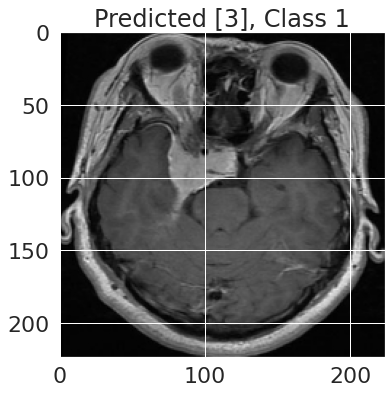

In [ ]:
n=649 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [1]
The actual label for this image is:  1


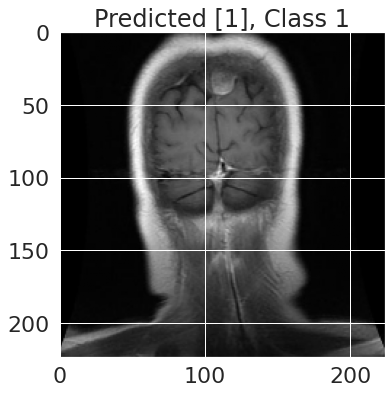

In [ ]:
n=590 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

The prediction for this image is:  [1]
The actual label for this image is:  0


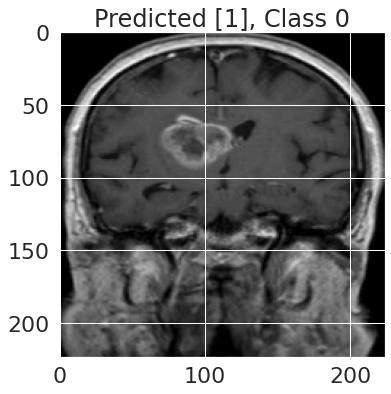

In [ ]:
n=90 #Select the index of image to be loaded for testing
img = X_Test[n]
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=cnn_model1.predict(input_img)
prediction_SV = SV_model.predict(input_img_features)[0]
prediction_SV = le.inverse_transform([prediction_SV])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_SV)
print("The actual label for this image is: ", Y_Test[n])
plt.figure(figsize = (6,6))
plt.imshow(img)
plt.title("Predicted {}, Class {}".format((prediction_SV),(Y_Test[n])))
plt.tight_layout()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout ,BatchNormalization, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D,AvgPool2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import os
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

model2 = Sequential()
model2.add(model_input)
model2.add(Conv2D(16, kernel_size=3,kernel_initializer='he_uniform',padding='valid',strides=(1,1),activation='relu', input_shape=(224,224,3)))
model2.add(MaxPool2D(4,4))
model2.add(BatchNormalization())



model2.add(Conv2D(64, kernel_size=3,kernel_initializer='he_uniform', strides=(1,1),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())


model2.add(Conv2D(128, kernel_size=3,kernel_initializer='he_uniform', strides=(1,1),activation='relu'))
model2.add(AvgPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))




#model2.add(Dropout(0.10))
model2.add(Flatten())
x=model2.output

x1=Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
x2=Dense(32, activation='relu',kernel_initializer='he_uniform')(x1)
prediction_layer=Dense(4, activation='softmax')(x2)
#p=model1.input
#q=model.input
#models=Concatenate(name='concatenation')([p, q])
#input1=model1.input
#input2=model.input
#concatInputs = keras.backend.concatenate([input1, input2],axis=0)
#cnn_models=Model(inputs=model_input, outputs=x2)
model1=Model(inputs=model_input, outputs=prediction_layer)
#cnn_model.save('/content/gdrive/MyDrive/model3.h5')
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0     

In [ ]:
model1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy'],
)
history=model1.fit(X_train,Y_train,epochs = 60 ,batch_size=16, validation_data = (X_test, Y_test),verbose=1)

Epoch 1/60
147/147 [==============================] - 15s 26ms/step - loss: 1.2593 - accuracy: 0.6309 - val_loss: 7.1038 - val_accuracy: 0.3206
Epoch 2/60
147/147 [==============================] - 2s 16ms/step - loss: 0.5695 - accuracy: 0.7867 - val_loss: 7.3057 - val_accuracy: 0.3779
Epoch 3/60
147/147 [==============================] - 2s 15ms/step - loss: 0.3476 - accuracy: 0.8714 - val_loss: 1.4680 - val_accuracy: 0.5840
Epoch 4/60
147/147 [==============================] - 2s 15ms/step - loss: 0.2301 - accuracy: 0.9208 - val_loss: 1.4196 - val_accuracy: 0.6374
Epoch 5/60
147/147 [==============================] - 3s 18ms/step - loss: 0.1685 - accuracy: 0.9421 - val_loss: 0.9057 - val_accuracy: 0.7748
Epoch 6/60
147/147 [==============================] - 2s 16ms/step - loss: 0.1348 - accuracy: 0.9613 - val_loss: 0.5342 - val_accuracy: 0.8511
Epoch 7/60
147/147 [==============================] - 2s 15ms/step - loss: 0.0699 - accuracy: 0.9783 - val_loss: 0.5222 - val_accuracy: 0.862

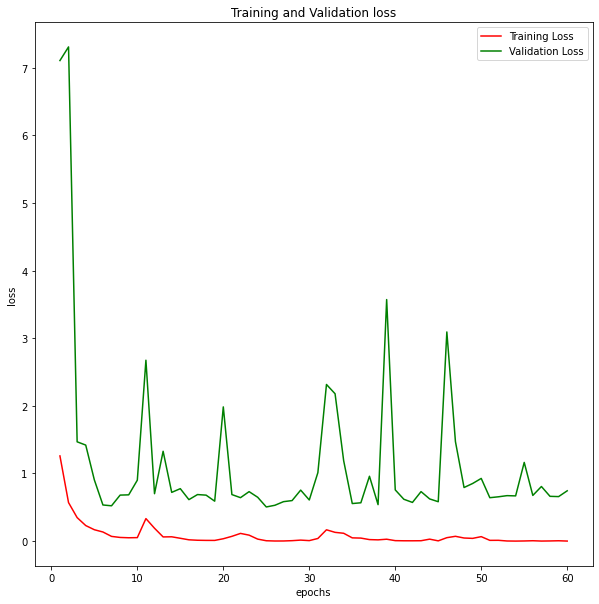

In [ ]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

              precision    recall  f1-score   support

      Glioma       0.83      0.88      0.85       185
  Meningioma       0.91      0.76      0.83       188
      Normal       0.88      0.88      0.88       100
   Pituitary       0.89      0.98      0.93       180

    accuracy                           0.87       653
   macro avg       0.88      0.87      0.87       653
weighted avg       0.87      0.87      0.87       653

Confusion Matrix
[[162  11   6   6]
 [ 26 143   6  13]
 [  6   3  88   3]
 [  2   1   0 177]]


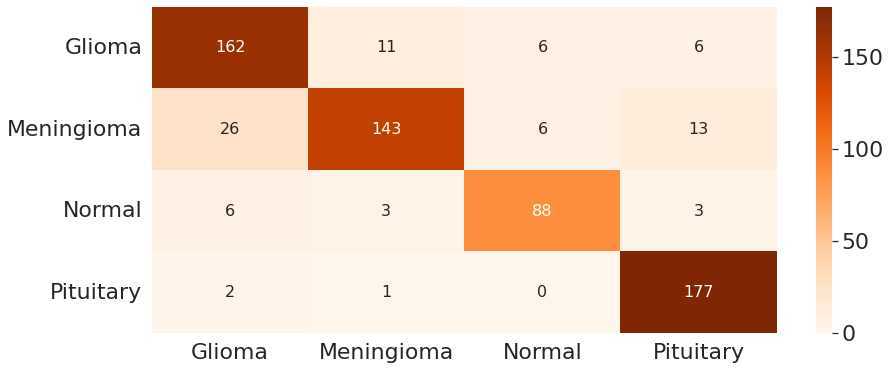

In [ ]:
target_names = ['Glioma','Meningioma','Normal','Pituitary']
predictions1 = model1.predict(X_Test)
predictions1=np.argmax(predictions1,axis=1)
#predictions = predictions.reshape(1,-1)[0]
print(classification_report(Y_Test, predictions1, target_names = ['Glioma','Meningioma','Normal','Pituitary']))
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
print('Confusion Matrix')
print(confusion_matrix(Y_Test, predictions1))
cm=confusion_matrix(Y_Test, predictions1)
#plt.figure(figsize=(5, 5))
#plt.imshow(cm)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm, index=["Glioma","Meningioma","Normal","Pituitary"], columns=["Glioma","Meningioma","Normal","Pituitary"])
plt.figure(figsize=(14,6))
sn.set(font_scale=2) # for label size
sn.heatmap(df_cm, annot=True,cmap='Oranges',fmt ='d', annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
model = Sequential()
model.add(model_input)
model.add(Conv2D(32, kernel_size=3,kernel_initializer='glorot_uniform',padding='valid',strides=(1,1),activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=3,kernel_initializer='glorot_uniform', strides=(1,1),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=3,kernel_initializer='glorot_uniform', strides=(1,1),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
x=model.output



x1=Dense(128, activation='relu',kernel_initializer='glorot_uniform')(x)
x2=Dense(32, activation='relu',kernel_initializer='glorot_uniform')(x1)
prediction_layer=Dense(4, activation='softmax')(x2)
#p=model1.input
#q=model.input
#models=Concatenate(name='concatenation')([p, q])
#input1=model1.input
#input2=model.input
#concatInputs = keras.backend.concatenate([input1, input2],axis=0)
#cnn_models=Model(inputs=model_input, outputs=x2)
model=Model(inputs=model_input, outputs=prediction_layer)
#cnn_model.save('/content/gdrive/MyDrive/model3.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0   

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy'],
)
history=model.fit(X_train,Y_train,epochs = 60 ,batch_size=16, validation_data = (X_test, Y_test),verbose=1)

Epoch 1/60
147/147 [==============================] - 8s 43ms/step - loss: 2.1905 - accuracy: 0.5266 - val_loss: 5.2956 - val_accuracy: 0.1947
Epoch 2/60
147/147 [==============================] - 5s 35ms/step - loss: 0.8041 - accuracy: 0.7178 - val_loss: 5.6884 - val_accuracy: 0.3015
Epoch 3/60
147/147 [==============================] - 5s 36ms/step - loss: 0.4902 - accuracy: 0.8127 - val_loss: 1.5668 - val_accuracy: 0.6031
Epoch 4/60
147/147 [==============================] - 5s 35ms/step - loss: 0.3837 - accuracy: 0.8557 - val_loss: 1.4247 - val_accuracy: 0.6298
Epoch 5/60
147/147 [==============================] - 5s 36ms/step - loss: 0.2300 - accuracy: 0.9166 - val_loss: 0.9154 - val_accuracy: 0.7672
Epoch 6/60
147/147 [==============================] - 5s 36ms/step - loss: 0.2237 - accuracy: 0.9289 - val_loss: 0.8844 - val_accuracy: 0.7595
Epoch 7/60
147/147 [==============================] - 5s 35ms/step - loss: 0.1283 - accuracy: 0.9570 - val_loss: 1.2823 - val_accuracy: 0.7252

              precision    recall  f1-score   support

      Glioma       0.88      0.78      0.83       185
  Meningioma       0.80      0.81      0.81       188
      Normal       0.91      0.86      0.88       100
   Pituitary       0.86      0.97      0.91       180

    accuracy                           0.86       653
   macro avg       0.86      0.86      0.86       653
weighted avg       0.86      0.86      0.85       653

Confusion Matrix
[[145  29   3   8]
 [ 15 153   5  15]
 [  4   5  86   5]
 [  0   4   1 175]]


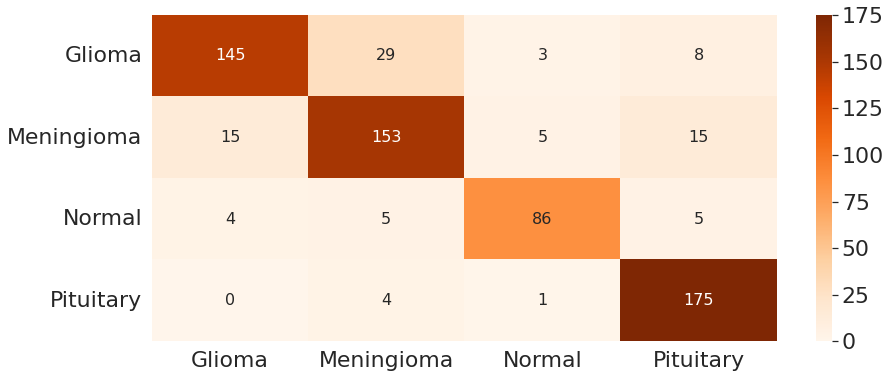

In [ ]:
target_names = ['Glioma','Meningioma','Normal','Pituitary']
predictions1 = model.predict(X_Test)
predictions1=np.argmax(predictions1,axis=1)
#predictions = predictions.reshape(1,-1)[0]
print(classification_report(Y_Test, predictions1, target_names = ['Glioma','Meningioma','Normal','Pituitary']))
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
print('Confusion Matrix')
print(confusion_matrix(Y_Test, predictions1))
cm=confusion_matrix(Y_Test, predictions1)
#plt.figure(figsize=(5, 5))
#plt.imshow(cm)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm, index=["Glioma","Meningioma","Normal","Pituitary"], columns=["Glioma","Meningioma","Normal","Pituitary"])
plt.figure(figsize=(14,6))
sn.set(font_scale=2) # for label size
sn.heatmap(df_cm, annot=True,cmap='Oranges',fmt ='d', annot_kws={"size": 16}) # font size

plt.show()

Accuracy =  0.8162327718223583


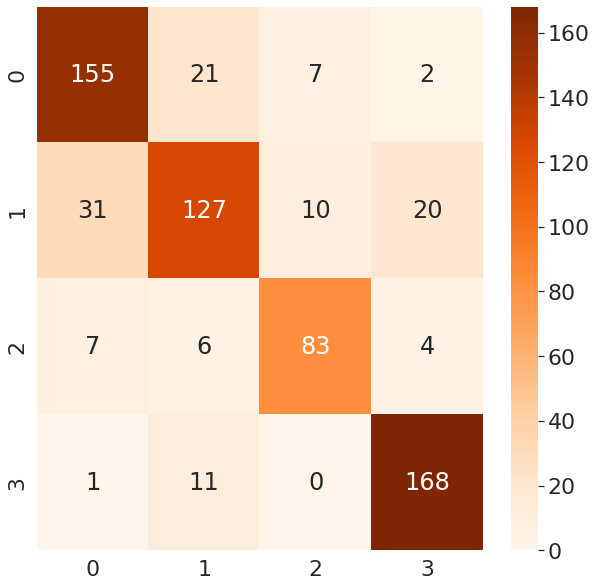

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)
# Training the model on training data
X_for_RF = model1.predict(X_train)
knn.fit(X_for_RF, train_labels_encoded)

#Sending test data through same feature extractor process
X_test_feature = model1.predict(X_Test)
#X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predicting using the trained RF model.

prediction_knn = knn.predict(X_test_feature)
#Inverse le transform to get original label back.
prediction_knn = le.inverse_transform(prediction_knn)

from sklearn import metrics

print ("Accuracy = ", metrics.accuracy_score(Y_Test, prediction_knn))

#Confusion Matrix - verify accuracy of each class
cm2 = confusion_matrix(Y_Test, prediction_knn)

plt.figure(figsize=(10,10))

sn.set(font_scale=2) # for label size

sns.heatmap(cm2, fmt='d',cmap='Oranges',annot=True,)

In [ ]:
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

model2 = Sequential()
model2.add(model_input)
model2.add(Conv2D(16, kernel_size=3,kernel_initializer='he_normal',padding='valid',strides=(1,1),activation='relu', input_shape=(224,224,3)))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())



model2.add(Conv2D(64, kernel_size=3,kernel_initializer='he_normal', strides=(1,1),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())


model2.add(Conv2D(128, kernel_size=3,kernel_initializer='he_normal', strides=(1,1),activation='relu'))
model2.add(AvgPool2D(2,2))
model2.add(BatchNormalization())





#model2.add(Dropout(0.10))
model2.add(Flatten())
x=model2.output

x1=Dense(128, activation='relu',kernel_initializer='he_normal')(x)
x2=Dense(32, activation='relu',kernel_initializer='he_normal')(x1)
prediction_layer=Dense(4, activation='softmax')(x2)
#p=model1.input
#q=model.input
#models=Concatenate(name='concatenation')([p, q])
#input1=model1.input
#input2=model.input
#concatInputs = keras.backend.concatenate([input1, input2],axis=0)
#cnn_models=Model(inputs=model_input, outputs=x2)
model2=Model(inputs=model_input, outputs=prediction_layer)
#cnn_model.save('/content/gdrive/MyDrive/model3.h5')
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 111, 111, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      9280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0   

In [ ]:
model2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy'],
)
history=model2.fit(X_train,Y_train,epochs = 60 ,batch_size=16, validation_data = (X_test, Y_test),verbose=1)

Epoch 1/60
147/147 [==============================] - 19s 35ms/step - loss: 1.8071 - accuracy: 0.5249 - val_loss: 4.7902 - val_accuracy: 0.3168
Epoch 2/60
147/147 [==============================] - 4s 28ms/step - loss: 1.1762 - accuracy: 0.5688 - val_loss: 1.6399 - val_accuracy: 0.4695
Epoch 3/60
147/147 [==============================] - 4s 27ms/step - loss: 1.1669 - accuracy: 0.5900 - val_loss: 0.9619 - val_accuracy: 0.5534
Epoch 4/60
147/147 [==============================] - 4s 29ms/step - loss: 0.7456 - accuracy: 0.6884 - val_loss: 1.0449 - val_accuracy: 0.5763
Epoch 5/60
147/147 [==============================] - 4s 27ms/step - loss: 0.7526 - accuracy: 0.6952 - val_loss: 0.8146 - val_accuracy: 0.6947
Epoch 6/60
147/147 [==============================] - 4s 27ms/step - loss: 0.6804 - accuracy: 0.7250 - val_loss: 2.2204 - val_accuracy: 0.5534
Epoch 7/60
147/147 [==============================] - 4s 29ms/step - loss: 0.6256 - accuracy: 0.7352 - val_loss: 1.0739 - val_accuracy: 0.618

              precision    recall  f1-score   support

      Glioma       0.80      0.81      0.80       185
  Meningioma       0.82      0.70      0.76       188
      Normal       0.90      0.84      0.87       100
   Pituitary       0.83      0.98      0.90       180

    accuracy                           0.83       653
   macro avg       0.84      0.83      0.83       653
weighted avg       0.83      0.83      0.83       653

Confusion Matrix
[[150  19   3  13]
 [ 31 132   6  19]
 [  5   8  84   3]
 [  2   2   0 176]]


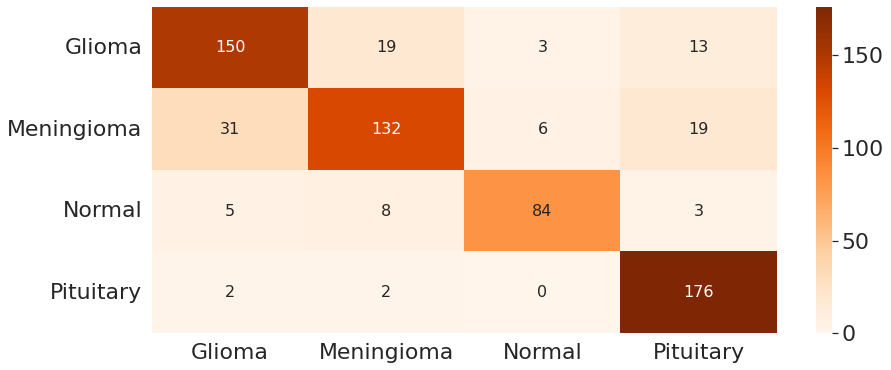

In [ ]:
target_names = ['Glioma','Meningioma','Normal','Pituitary']
predictions1 = model2.predict(X_Test)
predictions1=np.argmax(predictions1,axis=1)
#predictions = predictions.reshape(1,-1)[0]
print(classification_report(Y_Test, predictions1, target_names = ['Glioma','Meningioma','Normal','Pituitary']))
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
print('Confusion Matrix')
print(confusion_matrix(Y_Test, predictions1))
cm=confusion_matrix(Y_Test, predictions1)
#plt.figure(figsize=(5, 5))
#plt.imshow(cm)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm, index=["Glioma","Meningioma","Normal","Pituitary"], columns=["Glioma","Meningioma","Normal","Pituitary"])
plt.figure(figsize=(14,6))
sn.set(font_scale=2) # for label size
sn.heatmap(df_cm, annot=True,cmap='Oranges',fmt ='d', annot_kws={"size": 16}) # font size

plt.show()